[REINVENT4 の環境](https://github.com/136s/REINVENT4/blob/6f10c90112b5fb3ccccc765c0fe1d085de3bfeb4/requirements-macOS-conda.yml) で作成した環境で実行

# P. 57 予測分布

予測分布 $p_\theta(y|x)\coloneqq\bar{p}(y|\sigma(g_\theta(x)))$ (3.6)

$x$ -> 関数近似器 $g_\theta$ -> 活性化関数 $\sigma$ -> 条件付き確率分布 $\bar{p}(y|\bar{y})$ -> $y$

1. 関数近似器のみパラメタ $\theta$ に依存し、活性化関数や条件付き確率分布はパラメタに依存しない
2. 関数近似器は、出力空間 $\mathcal{Y}$ によらず、実数または実数値ベクトルを出力する

式 (3.6) の目的関数（= 損失関数）は $L(\theta;\mathcal{D})=\widehat{\mathbb{E}}_{(X,Y)\sim\mathcal{D}}[-\log\bar{p}(Y|\sigma(g_\theta(X)))]$ と表せる

最尤推定の枠組みの中では条件付き確率分布と損失関数が 1 対 1 に対応するため、$\bar{p}$ を損失関数とも呼べる

# P.61 PyTorch を用いた予測分布の実装

- 関数近似器: 線形モデル
    - 入力空間 $\mathcal{X}\subseteq\mathbb{R}^D$、パラメタ$\theta=\{\mathbf{w}\in\mathbb{R}^D,b\in\mathbb{R}\}$ のとき $g_\theta(\mathbf{x})=\mathbf{w}^\top\mathbf{x}+b$
    - `nn.Linear` クラス
- 活性化関数: シグモイド関数
    - $\mathcal{Y}=\{0,1\}$ のとき $\sigma(z)=\frac{1}{1+e^{-z}}$
- 条件付き確率分布: Bernoulli 分布
    - $\mathcal{Y}=\{0,1\}$、中間的な出力空間 $\bar{\mathcal{Y}}=[0,1]$、$y=1$ となる確率 $\bar{y}$ のとき $\bar{p}(y|\bar{y})=\text{Bern}(y;\bar{y})$
- 経験損失関数: 2 値交差エントロピー損失の期待値
    - $L(\theta;\mathcal{D})=\widehat{\mathbb{E}}_{(X,Y)\sim\mathcal{D}}[-Y\log f_\theta(X)-(1-Y)\log(1-f_\theta(X))]$

$\mathcal{X}=\mathbb{R}^5, \mathcal{Y}=\mathbb{R}$ に対応する線形モデルをつくる

## `nn.Module` クラス

数学的な関数を実装するベースクラスで、各構成要素がこれを継承している。
ほかのモジュールの構成要素や、複雑な構造の関数近似器を定義するために使う。
`nn.Module` クラスを継承するときは、`__init__()` と `forward()` メソッドを実装する必要がある。
`__init__()` は関数の内部で使うパラメタ（パラメタやパラメタを持つモジュール）、`forward()` はクラスで表現したい計算を手続き的に書く。

PyTorch には標準で、活性化関数と損失関数が一体になったモジュールが実装されている。
例えば、`nn.CrossEntropyLoss` は、ソフトマックス関数と交差エントロピー損失を組み合わせたものである。
また、`nn.BCELoss` は、2 値交差エントロピー損失とシグモイド関数を組み合わせたものである。
教師あり学習の場合、出力空間 $\mathcal{Y}$ が決まるとそれに応じて活性化関数と損失関数が決まるので、活性化関数と損失関数は対になる存在である。

In [1]:
# P.62 リスト3.1: 3/pred_func.py

import torch
from torch import nn

torch.manual_seed(46)

# 線形モデル（入力次元 5、出力次元 1）
m = nn.Linear(in_features=5, out_features=1)
print("model weight: {}".format(m.weight))
print("model bias: {}".format(m.bias))
print()

# 入力ベクトル
x = torch.ones(5)
# 出力ベクトル
y = m(x)  # m.forward(x) と等価
print("input: {}".format(x))
print("output: {}".format(y))
print()

# 複数（2 つ）の 5 次元ベクトルをまとめた行列を入力として与える
# 0 から 9 までの数字を 2 行 5 列の行列に変換
X = torch.arange(10, dtype=torch.float).reshape(2, 5)
# 2 つの入力ベクトルに対応する 2*1 の出力ベクトルを得る
Y = m(X)
print("input: {}".format(X))
print("output: {}".format(Y))
print()

# 活性化関数（シグモイド関数）を定義して適用
activation = nn.Sigmoid()
Y_bar = activation(m(X))
print("output: {}".format(Y_bar))
print()

target1 = torch.tensor([0.0, 1.0])
target2 = torch.tensor([1.0, 0.0])
# 2 値交差エントロピー損失
loss_func = nn.BCELoss()
loss1 = loss_func(Y_bar.reshape(-1), target1)
loss2 = loss_func(Y_bar.reshape(-1), target2)
print("target: {}\tloss: {}".format(target1, loss1))
print("target: {}\tloss: {}".format(target2, loss2))

model weight: Parameter containing:
tensor([[ 0.1441, -0.3936,  0.0156, -0.3044,  0.2281]], requires_grad=True)
model bias: Parameter containing:
tensor([0.3032], requires_grad=True)

input: tensor([1., 1., 1., 1., 1.])
output: tensor([-0.0070], grad_fn=<ViewBackward0>)

input: tensor([[0., 1., 2., 3., 4.],
        [5., 6., 7., 8., 9.]])
output: tensor([[-0.0600],
        [-1.6112]], grad_fn=<AddmmBackward0>)

output: tensor([[0.4850],
        [0.1664]], grad_fn=<SigmoidBackward0>)

target: tensor([0., 1.])	loss: 1.2283895015716553
target: tensor([1., 0.])	loss: 0.4528265595436096


# P.69 順伝播型ニューラルネットワーク (L=2) の実装

データ生成に用いるパラメタ $\mathbf{w}\in\mathbb{R}^2$

目的変数 $y=\sin\left(\mathbf{w}^\top\mathbf{x}\right)$

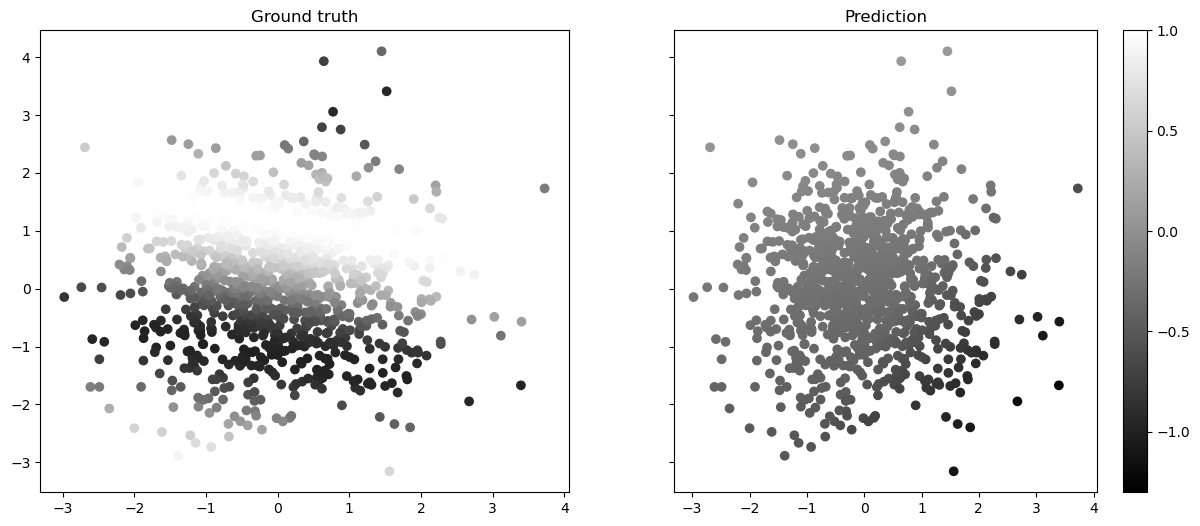

In [2]:
# P.70 リスト3.3: 3/fnn.py

import matplotlib.pyplot as plt
import torch
from torch import nn


class FeedforwardNeuralNetwork(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super(FeedforwardNeuralNetwork, self).__init__()
        # 線形関数 → 活性化関数 (ReLU) → 線形関数 を直列 (sequential) に繋ぐ
        self.fnn = nn.Sequential(
            nn.Linear(in_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.fnn(x)


# サンプルサイズ 1000 の 2 次元説明変数を標準正規分布に従って生成
torch.manual_seed(0)
in_dim = 2
sample_size = 1000
X = torch.randn((sample_size, in_dim))  # (1000, 2)
# データ生成に用いるパラメタを標準正規分布に従って生成
w = torch.randn(in_dim)  # (2,)
# 目的変数を生成
y = torch.sin(X @ w).reshape(-1, 1)  # (1000, 1)

# FFN モデルのインスタンスを生成（入力次元 2、中間層次元 2、出力次元 1）
model = FeedforwardNeuralNetwork(in_dim=in_dim, hidden_dim=2)

# 説明変数 X の予測値を得る
y_pred: torch.Tensor = model.forward(X)  # (1000, 1)

# ランダムな生成データと予測値の比較散布図をプロット
vmin = min(y.min(), y_pred.min())
vmax = max(y.max(), y_pred.max())
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 6))
im = ax1.scatter(X[:, 0], X[:, 1], c=y, cmap="gray", vmin=vmin, vmax=vmax)
ax1.set_title("Ground truth")
im = ax2.scatter(
    X[:, 0], X[:, 1], c=y_pred.detach().numpy(), cmap="gray", vmin=vmin, vmax=vmax
)
ax2.set_title("Prediction")
fig.colorbar(im, ax=ax2)
plt.savefig("fnn.pdf")
# plt.clf()

# 散布図の各点はデータセットの各事例 (1000) に対応し、濃さが目的変数の値の大きさに対応する

# P.74 誤差逆伝播法

- $L$ 層ニューラルネットワーク
- 入力: $\mathbf{x}\in\mathbb{R}^D$
- 出力: 実数値ラベル $\mathbf{y}\in\mathbb{R}$
- $l$ 層目 ($l\in[L]$): 非線型関数 $\mathbf{u}_l=W_l\mathbf{z}_l$（式 (3.17)）, $\mathbf{z}_{l+1}=\sigma_l(\mathbf{u}_l)$ （式 (3.18)）
    - 入力: $\mathbf{z}_l\in\mathbb{R}^{D_l}$
    - 活性化関数: $\sigma_l$
    - 出力: $\mathbf{z}_{l+1}\in\mathbb{R}^{D_{l+1}}$ （= $l+1$ 層目の入力）
    - $\mathbf{z}_0=\mathbf{x}$
    - $\mathbf{z}_L=y$
    - パラメタ: $W_l\in\mathbb{R}^{D_l\times D_{l+1}}$
        - $(i, j)\in[D_l]\times[D_{l+1}]$ 要素を $W_{lij}$ と表す
- 式 (3.17) と式 (3.18) をすべての $l\in[L]$ について合成したものを $y=f(\mathbf{x};W)$ とする

実数値ラベルを考えているため、1 事例あたりの損失関数は $\ell(W;\mathbf{x},y)=\frac{1}{2}(y-f(\mathbf{x};W))^2$ となる。この偏微分 $\frac{\partial \ell(W;\mathbf{x},y)}{\partial W_{lij}}$ を求める。




- $l$ 層目の重み $W_l$ から $\ell(W;\mathbf{x},y)$ への影響（= 偏微分）を分割
    - $W_l$ から $\mathbf{u}_l$ への影響
    - $\mathbf{u}_l$ から $\ell(W;\mathbf{x},y)$ への影響
        - $\mathbf{u}_l$ から $\mathbf{u}_{l+1}$ への影響
        - $\mathbf{u}_{l+1}$ から $\ell(W;\mathbf{x},y)$ への影響

この漸化式を用いて影響を計算する



In [3]:
# P.78 リスト3.4: 3/backprop.py

import torch

# 2 事例からデータ
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])  # (2, 3)
y = torch.tensor([1.0, 2.0])  # (2,)
# 3 次元パラメタ w
w = torch.tensor([1.0, 1.0, 1.0], requires_grad=True)  # (3,)
# 損失関数（式 (3.23)）の値を計算し、この過程で計算グラフを構築
loss = 0.5 * torch.sum((y - X @ w) ** 2)
print("loss = {}".format(loss))
# 計算グラフをもとに誤差逆伝播法を適用して、各パラメタに関する勾配の値を計算
loss.backward()
# 勾配の値
print("grad = {}".format(w.grad))

loss = 97.0
grad = tensor([57., 75., 93.])


# P.78 確率的勾配降下法

経験値最小化問題 (P.55) を解析的に解くことができないので、勾配法などで数値的に最適解を求める必要がある。
よく使われるのが確率的勾配降下法 stomachastic gradient descent である。

最急降下法 gradient descent は、目的関数の最小化を行うためのアルゴリズム。
例えば、$\hat\theta\in\argmin_{\theta\in\Theta}L(\theta;\mathcal{D})$（式 (3.5)）の最適化問題の場合、初期値 $\theta^{(0)}\in\Theta$ から初めて $k=0,1,\ldots,K-1$ に対して $\theta^{(k+1)}\leftarrow\theta^{(k)}-\alpha_k\frac{\partial L(\theta^{(k)};\mathcal{D})}{\partial\theta}$ と更新する。
最後の $\theta^{(K)}$ が $\hat\theta$ の最適解に近似する。
$\alpha_k\in\mathbb{R}_{>0}$ は学習率 learning rate である。
繰り返し毎に目的関数の勾配 $\frac{\partial L(\theta;\mathcal{D})}{\partial\theta}=\frac{1}{|\mathcal{D}|}\sum_{(x,y)\in\mathcal{D}}\frac{\partial\ell(\theta;x,y)}{\partial\theta}$ を計算する必要があり、データセットのサイズが大きくなるほど計算時間が長くなる。

確率的勾配降下法は真の勾配の代わりに、ランダムに選んだデータ点に対する勾配の不偏推定量を用いる。
データセットからランダムに取得した $(X,Y)\sim\mathcal{D}$ について $\frac{\partial\ell(\theta;X,Y)}{\partial\theta}$ は真の不偏推定量となる。


リスト 3.3 で定義したモデルと人工データを用いてリスト 3.4 と同じく `backward()` メソッドで誤差逆伝播法に基づいて勾配を推定する。
ただし、ここで計算しているのは訓練データに対する損失関数の値で、未知データへの予測性能は推定していない。

step: 100,		loss: 0.19409437477588654
step: 200,		loss: 0.020629867911338806
step: 300,		loss: 0.004414916969835758
step: 400,		loss: 0.0037620672956109047
step: 500,		loss: 0.005277616437524557
step: 600,		loss: 0.003880231874063611
step: 700,		loss: 0.004136078990995884
step: 800,		loss: 0.0030578812584280968
step: 900,		loss: 0.01134991180151701
step: 1000,		loss: 0.003733539953827858
step: 1100,		loss: 0.0012251547304913402
step: 1200,		loss: 0.0016262223944067955
step: 1300,		loss: 0.003423120826482773
step: 1400,		loss: 0.0021658348850905895
step: 1500,		loss: 0.001205865410156548
step: 1600,		loss: 0.0014685021014884114
step: 1700,		loss: 0.006261768750846386
step: 1800,		loss: 0.0019077485194429755
step: 1900,		loss: 0.0017477337969467044
step: 2000,		loss: 0.0029320777393877506
step: 2100,		loss: 0.0019618901424109936
step: 2200,		loss: 0.0022173619363456964
step: 2300,		loss: 0.0028520699124783278
step: 2400,		loss: 0.0006354749784804881
step: 2500,		loss: 0.00234191515482962

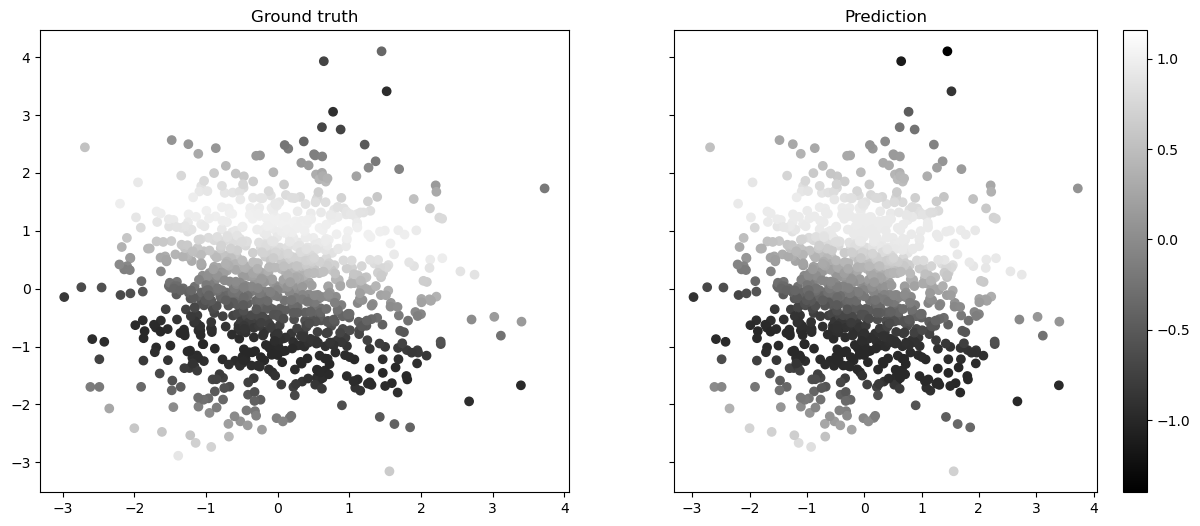

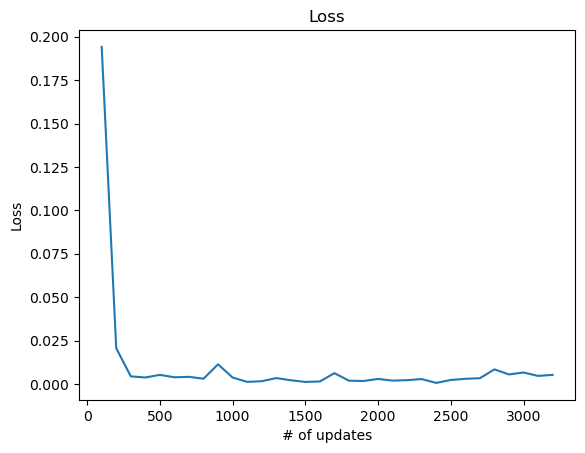

In [4]:
# P.82 リスト3.6: 3/sgd.py

import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader


# リスト3.3 と同じ
class FeedforwardNeuralNetwork(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super(FeedforwardNeuralNetwork, self).__init__()
        # 線形関数 → 活性化関数 (ReLU) → 線形関数 を直列 (sequential) に繋ぐ
        self.fnn = nn.Sequential(
            nn.Linear(in_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.fnn(x)


# サンプルサイズ 1000 の 2 次元説明変数を標準正規分布に従って生成（リスト3.3 と同じ）
torch.manual_seed(0)
sample_size = 1000
in_dim = 2
X = torch.randn((sample_size, in_dim))  # (1000, 2)
# データ生成に用いるパラメタを標準正規分布に従って生成
w = torch.randn(in_dim)  # (2,)
# 目的変数を生成
y = torch.sin(X @ w).reshape(-1, 1)  # (1000, 1)

# 生成したデータセットを PyTorch のデータセットに変換
dataset = TensorDataset(X, y)
# シャッフルありでミニバッチサイズ 32 のデータローダを生成
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# FFN モデルのインスタンスを生成（入力次元 2、中間層次元 2、出力次元 1）（リスト3.3 と同じ）
model = FeedforwardNeuralNetwork(in_dim=in_dim, hidden_dim=10)

# 損失関数のインスタンスを作成（実数値ラベルを予測するための損失関数として平均二乗誤差を用いる）
loss_func = nn.MSELoss()
# 最適化手法のインスタンスを作成（モデルパラメタの最適化に確率的勾配降下法 (SGD) を用いる）
# ここでは、確率的勾配降下法の中で Adaptive Moment Estimation を用いる
# 学習率 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
n_step = 0
loss_list = []
for each_epoch in range(100):
    for each_X, each_y in dataloader:  # 32 事例ずつランダムにデータを呼び出す
        # 誤差逆伝播法、確率的勾配降下法の 1 ステップを実行
        # モデルによる予測値
        each_pred = model.forward(each_X)
        # モデルによる予測値と真値から損失を計算
        loss: torch.Tensor = loss_func(each_pred, each_y)
        # backward() 実行の度に optimizer に勾配が累積されるため、勾配を 0 にリセット
        optimizer.zero_grad()
        # パラメータに関する損失の勾配を計算
        loss.backward()
        # 蓄積した勾配を元にパラメタを更新
        optimizer.step()

        n_step += 1
        if n_step % 100 == 0:
            print("step: {},\t\tloss: {}".format(n_step, loss.item()))
            loss_list.append((n_step, loss.item()))


# 説明変数 X の予測値を得る（リスト3.3 と同じ）
y_pred: torch.Tensor = model.forward(X)

# ランダムな生成データと予測値の比較散布図をプロット（リスト3.3 と同じ）
vmin = min(y.min(), y_pred.min())
vmax = max(y.max(), y_pred.max())
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 6))
im = ax1.scatter(X[:, 0], X[:, 1], c=y, cmap="gray", vmin=vmin, vmax=vmax)
ax1.set_title("Ground truth")
im = ax2.scatter(
    X[:, 0], X[:, 1], c=y_pred.detach().numpy(), cmap="gray", vmin=vmin, vmax=vmax
)
ax2.set_title("Prediction")
fig.colorbar(im, ax=ax2)
plt.savefig("sgd.pdf")
# plt.clf()

# 学習曲線 learning curve をプロット
fig, ax = plt.subplots(1, 1)
ax.plot(*list(zip(*loss_list)))
ax.set_title("Loss")
ax.set_xlabel("# of updates")
ax.set_ylabel("Loss")
plt.savefig("sgd_loss.pdf")
# plt.clf()

In [5]:
# P.101 リスト3.7: 3/metrics.py

from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np

y_true = np.array([0, 0, 1, 1, 1])
y_pred = np.array([0, 0, 1, 1, 0])
print("truth: {}".format(y_true))
print("pred: {}".format(y_pred))
print("accuracy: {}".format(accuracy_score(y_true, y_pred)))
print("precision: {}".format(precision_score(y_true, y_pred)))
print("recall: {}".format(recall_score(y_true, y_pred)))

truth: [0 0 1 1 1]
pred: [0 0 1 1 0]
accuracy: 0.8
precision: 1.0
recall: 0.6666666666666666


# P. 105 ドロップアウト

過剰適合を防ぐために、モデルの大きさを制限する正則化という手法がある。
繁用される正規化手法には正則化項、学習の早期停止、ドロップアウトなどがあり、ここではドロップアウトについて説明する。

ドロップアウト dropout は、ニューラルネットワークの学習中にランダムにニューロンを間引く。
$p\in[0,1]$ をハイパーパラメータとして、$\text{Dropout}_p:\mathbf{R}^D\rightarrow\mathbf{R}^D$ は、次のように定義される。

$\text{Dropout}_p(\mathbf{x})_d=\begin{cases}\frac{1}{1-p}x_d&{\text{（確率}1-p\text{）}}\\0&{\text{（確率}p\text{）}}\end{cases}(d=1,2,\dots,D)$ (3.36)

ドロップアウトによって、指数的に存在する初めのネットワーク構造の部分的なニューラルネットワークを表現できる。

In [6]:
# P.109 リスト3.9: 3/dropout.py

import torch
from torch import nn

torch.manual_seed(43)
dropout_layer = nn.Dropout(p=0.5)
input_tensor = torch.ones(10)

print(" * train mode")
dropout_layer.train()  # 訓練モードに切り替え（ドロップアウト有効）
for _ in range(3):
    print(dropout_layer(input_tensor))

print(" * evaluation mode")
dropout_layer.eval()  # 評価モードに切り替え（ドロップアウト無効）
for _ in range(3):
    print(dropout_layer(input_tensor))

 * train mode
tensor([0., 2., 2., 0., 0., 0., 2., 2., 2., 0.])
tensor([0., 0., 2., 0., 0., 0., 2., 2., 2., 0.])
tensor([0., 0., 2., 0., 0., 0., 0., 2., 2., 2.])
 * evaluation mode
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


# P. 115 `deepchem` を用いた MoleculeNet のデータ取得とその図示

[MoleculeNet](https://moleculenet.org/) は、分子構造からのその物性値を予測する問題を集めたベンチマークであり、`deepchem` で提供される。


In [ ]:
! pip install 'deepchem[torch]'

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (/opt/miniconda3/envs/reinvent4/lib/python3.11/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/opt/miniconda3/envs/reinvent4/lib/python3.11/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped lo

train_set: 
       X_shape    y_shape
0  (1210, 210)  (1210, 1)
val_set: 
      X_shape   y_shape
0  (151, 210)  (151, 1)
test_set: 
      X_shape   y_shape
0  (152, 210)  (152, 1)
y_mean, y_std = 3.1475281517968074e-15, 0.9999999999999999


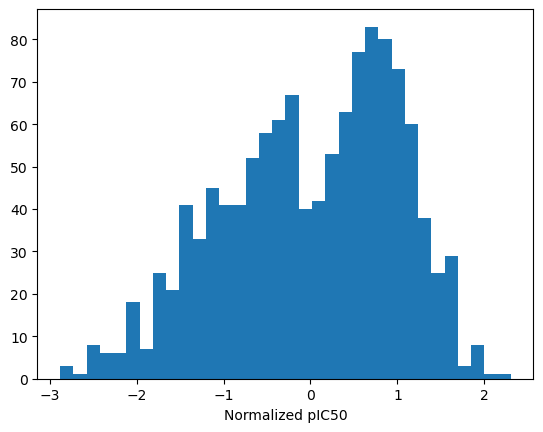

In [7]:
# P.116 リスト3.11: 3/deepchem_dataload.py

import matplotlib.pyplot as plt
import numpy as np
import deepchem as dc  # v2.7.1

# 特徴量抽出器（構造式から特徴量ベクトルに変換する）として、RDKit の記述子（208 個）を用いる
featurizer = dc.feat.RDKitDescriptors()
# Molenet から、回帰問題設定の BACE データセット（BACE-1 阻害薬の構造式とその IC50 のセット）を読み込む
# 引数の初期値で、分子骨格を基にデータセットを分割し、目的変数を標準化している
# tasks: データセットに対して定義されているタスクのリスト（ここでは pIC50 のみ）
# datasets: 訓練データ、検証用データ、テストデータのタプル
# transformers: データセットに対して適用される変換器のリスト
tasks, datasets, transformers = dc.molnet.load_bace_regression(featurizer)

# 1210, 151, 152 事例の訓練、検証、テストセットに分割
train_set, val_set, test_set = datasets
# 訓練データの、サンプルサイズ × 特徴量ベクトルの次元
print("train_set: \n{}".format(train_set.metadata_df.iloc[:, 5:7]))
# 検証データの、サンプルサイズ × 特徴量ベクトルの次元
print("val_set: \n{}".format(val_set.metadata_df.iloc[:, 5:7]))
# テストデータの、サンプルサイズ × 特徴量ベクトルの次元
print("test_set: \n{}".format(test_set.metadata_df.iloc[:, 5:7]))
# 訓練セットの目的変数の分布
print("y_mean, y_std = {}, {}".format(np.mean(train_set.y), np.std(train_set.y)))
# 訓練データの目的変数のヒストグラム → 標準正規分布となっていることを確認
plt.hist(train_set.y, bins=int(np.sqrt(len(train_set.y))))
plt.xlabel("Normalized pIC50")
plt.savefig("bace_y_train.pdf")
# plt.clf()

step: 0,		train loss: 506.0571983148244
step: 0,		val loss: 592.9058748965232
step: 100,		train loss: 1.375315995649858
step: 100,		val loss: 0.8818949768874819
step: 200,		train loss: 0.9390338188360545
step: 200,		val loss: 0.40744918229564137
step: 300,		train loss: 0.6475228979567851
step: 300,		val loss: 0.6247011904684913
step: 400,		train loss: 0.6108840839921935
step: 400,		val loss: 0.3615115399392235
step: 500,		train loss: 0.508750352780681
step: 500,		val loss: 0.7068781821143548
step: 600,		train loss: 0.5133236971768466
step: 600,		val loss: 0.3356139138834366
step: 700,		train loss: 0.4026471157704503
step: 700,		val loss: 0.3915586250507279
step: 800,		train loss: 0.43523685991271466
step: 800,		val loss: 0.3503262980884274
step: 900,		train loss: 0.3701023960901686
step: 900,		val loss: 0.42288395584813804
step: 1000,		train loss: 0.4915114134796395
step: 1000,		val loss: 0.8480864518525585
step: 1100,		train loss: 0.3449510503406367
step: 1100,		val loss: 0.4543304917

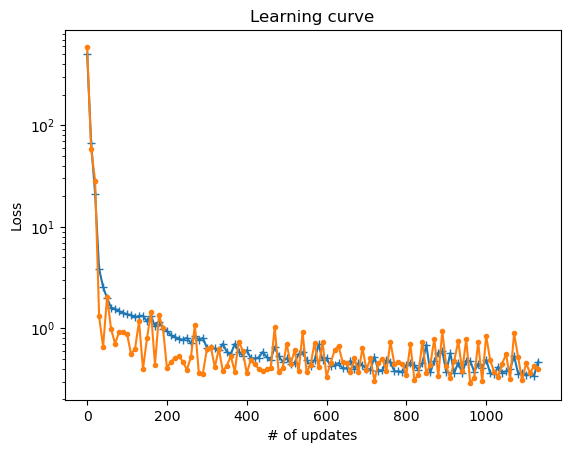

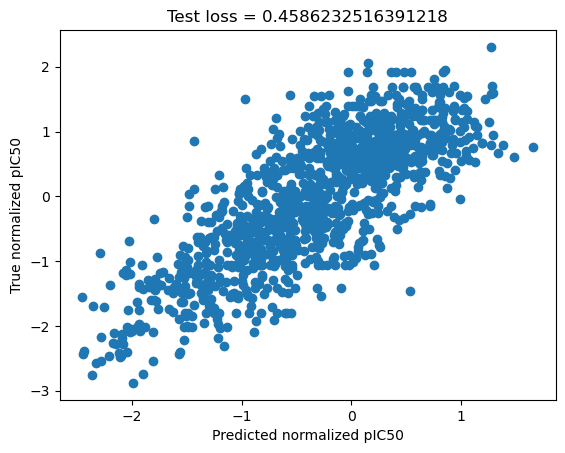

In [8]:
# P.118 リスト3.13: 3/deepchem_main.py

import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from deepchem.feat.molecule_featurizers import RDKitDescriptors
from deepchem.molnet.load_function.bace_datasets import load_bace_regression

# from fnn import FeedforwardNeuralNetwork


# リスト3.3 と同じ
class FeedforwardNeuralNetwork(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super(FeedforwardNeuralNetwork, self).__init__()
        # 線形関数 → 活性化関数 (ReLU) → 線形関数 を直列 (sequential) に繋ぐ
        self.fnn = nn.Sequential(
            nn.Linear(in_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.fnn(x)


torch.manual_seed(43)


def loss_evaluator(
    dataloader: DataLoader, model: FeedforwardNeuralNetwork, loss_func: torch.nn.Module
) -> tuple[float, list[list[float]], list[list[float]]]:
    # データローダ、モデル、損失関数が与えられた下で、1 事例あたりの平均的な損失の値と、予測値のリスト、実測値のリストを返す
    sample_size = len(dataloader.dataset)
    pred_list = []
    true_list = []
    with torch.no_grad():
        loss = 0
        for each_X, each_y in dataloader:
            each_pred = model.forward(each_X)
            pred_list.extend(each_pred.tolist())
            true_list.extend(each_y.tolist())
            loss += loss_func(each_pred, each_y).item()
    return loss / sample_size, pred_list, true_list


# 特徴量抽出器（構造式から特徴量ベクトルに変換する）として、RDKit の記述子（208 個）を用いる（リスト3.11 と同じ）
featurizer = RDKitDescriptors()
# Molenet から、回帰問題設定の BACE データセット（BACE-1 阻害薬の構造式とその IC50 のセット）を読み込む（リスト3.11 と同じ）
# 引数の初期値で、分子骨格を基にデータセットを分割し、目的変数を標準化している
# tasks: データセットに対して定義されているタスクのリスト（ここでは pIC50 のみ）
# datasets: 訓練データ、検証用データ、テストデータのタプル
# transformers: データセットに対して適用される変換器のリスト
tasks, datasets, transformers = load_bace_regression(featurizer)

# 1210, 151, 152 事例の訓練、検証、テストセットに分割（リスト3.11 と同じ）
train_set, val_set, test_set = datasets

# シャッフルありでミニバッチサイズ 32 で訓練データののデータローダを生成
train_dataloader = DataLoader(
    TensorDataset(torch.FloatTensor(train_set.X), torch.FloatTensor(train_set.y)),
    batch_size=32,
    shuffle=True,
)
# シャッフルありでミニバッチサイズ 32 で検証データののデータローダを生成
val_dataloader = DataLoader(
    TensorDataset(torch.FloatTensor(val_set.X), torch.FloatTensor(val_set.y)),
    batch_size=32,
    shuffle=True,
)
# シャッフルありでミニバッチサイズ 32 でテストデータののデータローダを生成
test_dataloader = DataLoader(
    TensorDataset(torch.FloatTensor(test_set.X), torch.FloatTensor(test_set.y)),
    batch_size=32,
    shuffle=True,
)

# FFN モデルのインスタンスを生成（入力次元 208、中間層次元、出力次元 1）
model = FeedforwardNeuralNetwork(in_dim=train_set.X.shape[1], hidden_dim=32)
# 損失関数のインスタンスを作成
loss_func = nn.MSELoss(reduction="sum")
# 最適化手法のインスタンスを作成（モデルパラメタの最適化に確率的勾配降下法 (SGD) を用いる）
# weight_decay で L2 正則化項を追加して、過剰適合を軽減している
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
n_step = 0
train_loss_list = []
val_loss_list = []
for each_epoch in range(30):
    for each_X, each_y in train_dataloader:
        if n_step % 10 == 0:
            # 訓練損失を計算
            train_loss, _, _ = loss_evaluator(train_dataloader, model, loss_func)
            # 検証損失を計算
            val_loss, _, _ = loss_evaluator(val_dataloader, model, loss_func)
            if n_step % 100 == 0:
                print("step: {},\t\ttrain loss: {}".format(n_step, train_loss))
                print("step: {},\t\tval loss: {}".format(n_step, val_loss))
            train_loss_list.append((n_step, train_loss))
            val_loss_list.append((n_step, val_loss))

        each_pred = model.forward(each_X)
        loss = loss_func(each_pred, each_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        n_step += 1


fig, ax = plt.subplots(1, 1)
ax.plot(*list(zip(*train_loss_list)), marker="+")
ax.plot(*list(zip(*val_loss_list)), marker=".")
ax.set_title("Learning curve")
ax.set_xlabel("# of updates")
ax.set_ylabel("Loss")
ax.set_yscale("log")
plt.savefig("bace_loss.pdf")
# plt.clf()

# テスト損失、予測値のリスト、実測値のリストを得る
test_loss, pred_list, true_list = loss_evaluator(train_dataloader, model, loss_func)
print("test_loss: {}".format(test_loss))

fig, ax = plt.subplots(1, 1)
ax.scatter(pred_list, true_list)
ax.set_title("Test loss = {}".format(test_loss))
ax.set_xlabel("Predicted normalized pIC50")
ax.set_ylabel("True normalized pIC50")
plt.savefig("bace_scatter.pdf")
# plt.clf()